In [1]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import argparse
import os
import random
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image,ImageOps,ImageFilter
import cv2

from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/Colab Notebooks/data/'

ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


Mounted at /content/drive


In [2]:
import torch.nn as nn
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [3]:

image_size = 64
# Number of channels in the training images.
nc = 5
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 128



# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# # Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 5, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


In [4]:
def load_model(filepath, modelG):
    if os.path.isfile(filepath):
        print(f"Loading model at '{filepath}'")
        checkpoint = torch.load(filepath)
        modelG.load_state_dict(checkpoint['generator_state_dict'])
        G_losses = checkpoint.get('G_losses', [])
        D_losses = checkpoint.get('D_losses', [])

        print(f"Loaded '{filepath}'")
    return G_losses, D_losses

G_losses, D_losses = load_model('/content/drive/MyDrive/Colab Notebooks/final_model.pth', netG)

Loading model at '/content/drive/MyDrive/Colab Notebooks/final_model.pth'
Loaded '/content/drive/MyDrive/Colab Notebooks/final_model.pth'


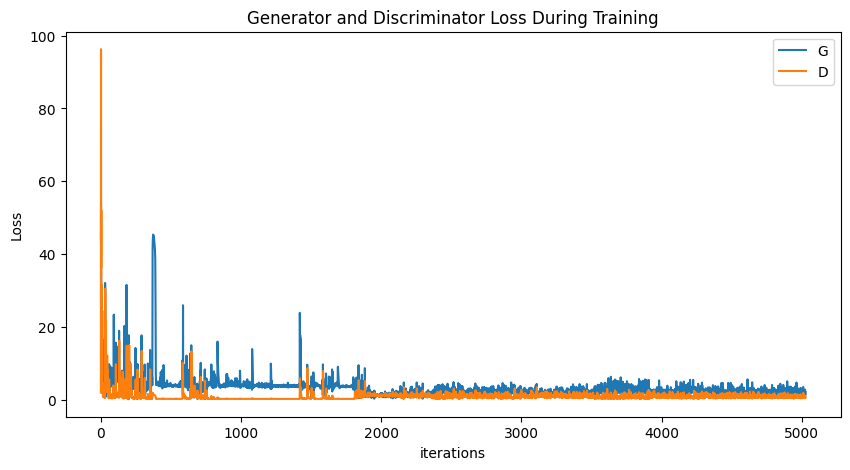

In [5]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

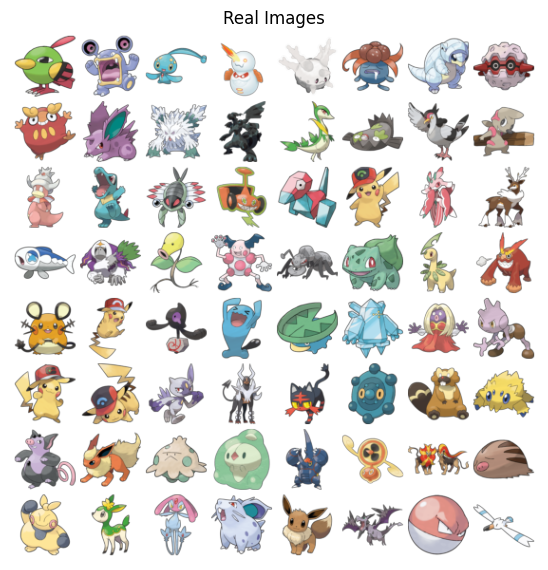

In [12]:
def edge_detection(image):
    # Convert PIL image to a numpy array
    numpy_image = np.array(image.convert('L'))  # Convert to grayscale
    # Perform Canny edge detection
    edges = cv2.Canny(numpy_image, threshold1=100, threshold2=200)
    # Dilate the edges to make them more pronounced
    kernel = np.ones((3, 3), np.uint8)
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)

    return edges_dilated


class AddEdgesTransform(object):
    def __call__(self, img):
        # Ensure img is in RGBA
        img_rgba = img.convert('RGBA')
        # Apply edge detection, make sure edges is in 'L' mode for blending
        edges = edge_detection(img_rgba).convert('L')
        # Create a new RGBA image from edges for blending
        edges_rgba = Image.merge('RGBA', (edges, edges, edges, img_rgba.split()[3]))  # Use original alpha
        # Blend the original image with the edges image
        combined = Image.blend(img_rgba, edges_rgba, alpha=0.5)
        return combined

def pil_loader_rgba(path: str) -> torch.Tensor:
    with open(path, 'rb') as f:
        img = Image.open(f).convert('RGBA')
        # Perform edge detection and get the edges as a numpy array
        edges = edge_detection(img)
        # Stack the RGBA channels and edge channel
        img_np = np.array(img)
        img_with_edges_np = np.concatenate((img_np, edges[:, :, None]), axis=2)
        # Convert to PyTorch tensor
        img_with_edges_tensor = torch.tensor(img_with_edges_np.transpose((2, 0, 1)), dtype=torch.float32) / 255.0  # Normalize to [0, 1]
        return img_with_edges_tensor

image_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Normalize((0.5, 0.5, 0.5, 0.5, 0.5), (0.5, 0.5,0.5, 0.5, 0.5))])


dataset = datasets.DatasetFolder(root=data_path, loader=pil_loader_rgba, extensions=['png'], transform=image_transforms)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))
real_images = real_batch[0][:, :4, :, :]  # Select only RGBA channels, drop the edge channel

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_images.to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))


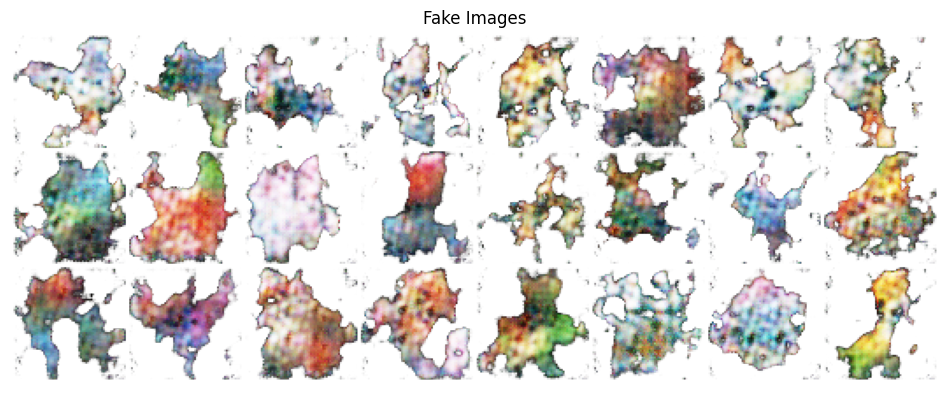

In [49]:
NUM_IMAGES = 24


noise = torch.randn(NUM_IMAGES, nz, 1, 1, device=device)
img_list = []
with torch.no_grad():
    fake = netG(noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
fake_images = img_list[-1][:4,:,:]

plt.figure(figsize=(12,12))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fake_images,(1,2,0)))
plt.show()